# Newton method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax

# We enable double precision in JAX
from jax.config import config
config.update("jax_enable_x64", True)

<ipython-input-1-b0110fdc4214>:8: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


We consider a random matrix $A \in \mathbb{R}^{n\times n}$, with $n = 100$ and a random vector $\mathbf{x}_{\text{ex}} \in \mathbb{R}^n$.
We define then $\mathbf{b} = A \, \mathbf{x}_{\text{ex}}$.

In [2]:
n = 100

np.random.seed(0)
A = np.random.randn(n,n)
x_ex = np.random.randn(n)
b = A @ x_ex

Define the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_2^2
$$

In [3]:
def loss(x):
  return jnp.sum(jnp.square(A @ x - b))

print(loss(x_ex))

0.0


By using the `jax` library, implement and compile functins returning the gradient ($\nabla \mathcal{J}(\mathbf{x})$) and the hessian ($\nabla^2 \mathcal{J}(\mathbf{x})$) of the loss function.

In [4]:
grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

Check that the results are correct (up to machine precision).

In [5]:
np.random.seed(0)
x_guess = np.random.randn(n)

G_ad = grad_jit(x_guess)              #our gradient computed with auto diff
G_ex = 2 * A.T @ (A @ x_guess - b)    #exact gradient
print(np.linalg.norm(G_ad - G_ex))

H_ad = hess_jit(x_guess)              #automatic diff
H_ex = 2 * A.T @ A                    #exact
print(np.linalg.norm(H_ad - H_ex))

2.1758506481219884e-12
5.158348193743819e-13


Exploit the formula
$$
\nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v} = \nabla_{\mathbf{x}} \phi(\mathbf{x}, \mathbf{v})
$$
where
$$
\phi(\mathbf{x}, \mathbf{v}) := \nabla \mathcal{J}(\mathbf{x}) \cdot \mathbf{v}
$$
to write an optimized function returning the hessian-vector-product
$$
(\mathbf{x}, \mathbf{v}) \mapsto \nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v}.
$$
Compare the computational performance w.r.t. the full hessian computation.

In [6]:
np.random.seed(1)
v = np.random.randn(n)

hvp_basic = lambda x, v: hess(x) @ v
gvp = lambda x, v : jnp.dot(grad(x), v)               #gvp = phi function
hvp = lambda x, v : jax.grad(gvp, argnums = 0)(x, v)  #hessian vector product

hvp_basic_jit = jax.jit(hvp_basic)
hvp_jit = jax.jit(hvp)

Hv_ad = hvp_jit(x_guess, v)
Hv_ex = H_ex @ v
print(np.linalg.norm(Hv_ad - Hv_ex))

1.2649657273878854e-12


In [9]:
%timeit hvp_basic_jit(x_guess, v)
%timeit hvp_jit(x_guess, v)

559 µs ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
12.8 µs ± 513 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Implement the Newton method for the minimization of the loss function $\mathcal{L}$. Set a maximim number of 100 iterations and a tolerance on the increment norm of $\epsilon = 10^{-8}$.

In [10]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

for epoch in range(num_epochs):
  l = loss_jit(x)
  H = hess_jit(x)
  G = grad_jit(x)
  incr = np.linalg.solve(H, -G)       #H*deltaX = -G
  x += incr

  print('============ epoch %d' % epoch)
  print('loss: %1.3e' % l)
  print('grad: %1.3e' % np.linalg.norm(G))
  print('incr: %1.3e' % np.linalg.norm(incr))

  if np.linalg.norm(incr) < eps:
    break

print('relative error: %1.3e' % (np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)))

============ epoch 0
loss: 3.739e+04
grad: 6.026e+03
incr: 1.548e+01
============ epoch 1
loss: 5.134e-22
grad: 2.880e-12
incr: 2.368e-09
relative error: 4.894e-15


Repeat the optimization loop for the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_4^4
$$

In [11]:
def loss(x):
  return jnp.sum((A @ x - b)**4)
grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

convergence reached!
epochs: 50
relative error: 1.657e-09


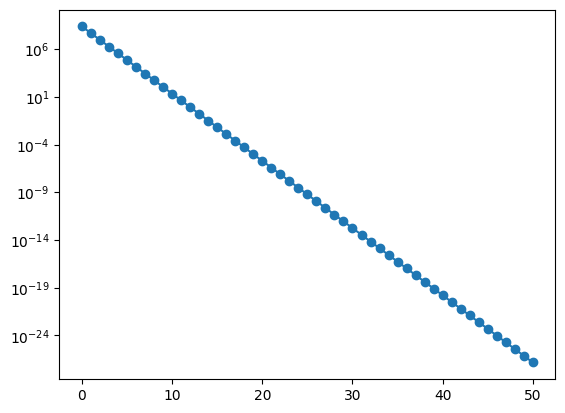

In [12]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

#hist = [loss_jit(x)]
hist = []
t0 = time.time()
for epoch in range(num_epochs):
  l = loss_jit(x)
  hist.append(l)
  H = hess_jit(x)
  G = grad_jit(x)
  incr = np.linalg.solve(H, -G)
  x += incr
  if np.linalg.norm(incr) < eps:
    print("convergence reached!")
    break
ttot = time.time() - t0

plt.semilogy(hist, 'o-')
print('epochs: %d' % epoch)
print('relative error: %1.3e' % (np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)))